In [1]:
# Se instalan las librerías necesarias
!pip install transformers torch pandas tables

In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm.notebook import tqdm

In [3]:
# Conexión a Google Drive para el intercambio de archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Se procesan las columnas Essay con DistilBert
# El objetivo es convertir las columnas essay en representaciones vectoriales usando la técnica de procesamiento de lenguaje natural de DistilBert
# Se fuerza a que PyTorch utilice la GPU en vez de la CPU para acelerar el procesamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Se carga el tokenizador preentrenado distilbert-base-uncased para convertir las columnas essay en tokens
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Se carga el modelo en la GPU
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

# Se establece el modelo en modo de evaluación para garantizar que se comporte de manera coherente
model.eval()

# Se define la función que procesará las columnas essay
def process_batch(batch_texts):
    '''
    Procesa un texto utilizando el tokenizador y el modelo preentrenado de DistilBERT.

    Args:
        batch_texts (list of str): Texto a procesar.

    Returns:
        numpy.ndarray: Una matriz con las representaciones vectoriales de los textos procesados.
    '''
    inputs = tokenizer(batch_texts,
                       padding=True, # Agrega relleno a las columnas de texto para que tengan todas la misma longitud
                       return_tensors="pt" # Devuelve tensores PyTorch
                       ).to(device) # Mueve los datos tokenizados a la GPU
    # Pasa los datos tokenizados al modelo para obtener los outputs
    outputs = model(**inputs)
    # El resultado que devuelve es una matriz numpy con la media de los vectores
    return outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy()

# Se define otra función para procesar y guardar los datos en formato HDF5
def process_and_save(data, column_names, batch_size=32, save_every_n_batches=100):
    '''
    Procesa los datos de texto en lotes, guarda el progreso periódicamente en formato HDF5 y
    guarda el último lote en formato HDF5. La función utiliza la función
    process_batch definida anteriormente para procesar cada lote de textos.

    Args:
        data (pandas.DataFrame): El dataframe que contiene los datos a procesar.
        column_names (list of str): Lista de nombres de las columnas en 'data' que contienen los textos a procesar.
        batch_size (int): Tamaño del lote para procesar.
        save_every_n_batches (int): Frecuencia con la que se guarda el progreso en formato HDF5.

    Returns:
        None
    '''
    for col in column_names:
        all_features = []
        for i in tqdm(range(0, len(data), batch_size), desc=f"Procesando {col}"):
            # Itera cada columna y convierte un lote de texto en una lista
            batch_texts = data[col].fillna('').iloc[i:i+batch_size].tolist()
            # Procesa el lote de texto usando la función process_batch
            batch_features = process_batch(batch_texts)
            # Extiende los resultados del procesamiento
            all_features.extend(batch_features)

            # Se guarda el progreso periódicamente en formato HDF5 con un nombre basado en la columna essay y su iteración
            if (i // batch_size) % save_every_n_batches == 0:
                processed_df = pd.DataFrame(all_features)
                processed_df.to_hdf(f"/content/drive/My Drive/processed_{col}_{i // batch_size}.h5", key='data', mode='w')

        # Se guarda el último lote del procesamiento de cada columna con el sufijo final
        processed_df = pd.DataFrame(all_features)
        processed_df.to_hdf(f"/content/drive/My Drive/processed_{col}_final.h5", key='data', mode='w')

# Se cargan los datos que se generaron tras ejecutar el script anterior
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ok_cupid.csv')

# Se definen las columnas a procesar
essay_columns = ['essay0_tokens', 'essay1_tokens', 'essay2_tokens', 'essay3_tokens',
                 'essay4_tokens', 'essay5_tokens', 'essay6_tokens', 'essay7_tokens',
                 'essay8_tokens', 'essay9_tokens']

# Se procesan las columnas
process_and_save(data, essay_columns)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Procesando essay0_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay1_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay2_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay3_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay4_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay5_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay6_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay7_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay8_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

Procesando essay9_tokens:   0%|          | 0/1872 [00:00<?, ?it/s]

In [ ]:
# Se fusionan cada una de las columnas BERT con el dataset original
file_path = '/content/drive/My Drive/Colab Notebooks/ok_cupid.csv'
data = pd.read_csv(file_path)

# Se itera para cada uno de los ficheros de Essay generados
for i in range(10):
    bert_features_path = f'/content/drive/My Drive/processed_essay{i}_tokens_final.h5'

    # Se cargan los vectores BERT
    bert_features_df = pd.read_hdf(bert_features_path, key='data')
    bert_features_df.columns = [f'essay{i}_token_{j}' for j in range(bert_features_df.shape[1])]

    # Se concatenan los resultados de cada columna al dataframe principal
    data = pd.concat([data, bert_features_df], axis=1)

    # Se guarda el dataframe después de cada unión en un fichero ok_cupid_joined_Nr en formato HDF5
    intermediate_path = f'/content/drive/My Drive/ok_cupid_joined_{i}.h5'
    data.to_hdf(intermediate_path, key='data', mode='w')

    print(f'Archivo {i} procesado y guardado en formato HDF5.')

    # Se libera de la memoria las columnas BERT
    del bert_features_df

<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 0 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 1 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 2 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 3 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 4 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 5 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 6 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 7 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 8 procesado y guardado en formato HDF5.


<ipython-input-4-d9df5cbd6486>:20: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf(intermediate_path, key='data', mode='w')


Archivo 9 procesado y guardado en formato HDF5.


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Se carga el dataset completo con los vectores Bert
data = pd.read_hdf('/content/drive/My Drive/ok_cupid_joined_9.h5', key='data')

# Se aplica la codificación One-Hot a las columnas categóricas
print("Aplicando codificación One-Hot a las columnas categóricas...")
categorical_columns = ['age_category','sex', 'orientation', 'body_type', 'drinks',  'education', 'ethnicity', 'job']
categorical_data = data[categorical_columns]
encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(categorical_data)

# Se crea un nuevo dataframe con las columnas codificadas
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

# Se concatenan las nuevas columnas al dataframe original
data = pd.concat([data, categorical_encoded_df], axis=1)

# Se guarda el resultado en formato hdf5
data.to_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_full_data.h5', key='data', mode='w')
print("Datos preparados y guardados, manteniendo columnas categóricas originales.")

Aplicando codificación One-Hot a las columnas categóricas...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-5-374e9b063e78>:21: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf('/content/drive/My Drive/ok_cupid_full_data.h5', key='da

Datos preparados y guardados, manteniendo columnas categóricas originales.


In [7]:
# Se limpia el dataframe de valores nulos antes de hacer el clustering
# data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_full_data.h5', key='data')

# Se seleccionan las columnas numéricas
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Se crea un nuevo dataframe con las columnas numéricas
data_numeric = data[numeric_columns]
columns_to_exclude= ['income']

# El nuevo dataframe data_for_clustering contiene las columnas numéricas, pero no las que se excluyen
data_for_clustering = data_numeric.drop(columns=columns_to_exclude)

# Se calcula el número de nulos por columna
nan_counts = data_for_clustering.isnull().sum()

# Se comprueba la existencia de columnas con valores nulos
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)
print(nan_counts)

# Para a continuación eliminar aquellas filas con valores nulos
data_for_clustering = data_for_clustering.dropna()


essay0_token_0      2
essay0_token_1      2
essay0_token_2      2
essay0_token_3      2
essay0_token_4      2
                   ..
essay9_token_763    2
essay9_token_764    2
essay9_token_765    2
essay9_token_766    2
essay9_token_767    2
Length: 7680, dtype: int64
age                   0
height                0
cluster               0
essay0_token_0        2
essay0_token_1        2
                     ..
job_rather not say    0
job_service           0
job_student           0
job_tech              0
job_unemployed        0
Length: 7732, dtype: int64


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Se carga el dataset de trabajo si fuera necesario
# data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_full_data.h5', key='data')

# Se clusteriza usando K-means con 4 clústers
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_for_clustering)

# Se asignan los clústers a la columna k_means_cluster
data_for_clustering['kmeans_cluster'] = kmeans.labels_

# Se añade la columna con los clústeres al dataframe original
data['kmeans_cluster'] = data_for_clustering['kmeans_cluster']

# Se exportan los resultados
data.to_hdf('/content/drive/My Drive/ok_cupid_final_clusters.h5', key='data', mode='w')
print("Conjunto de datos con clusters guardado: ok_cupid_final_clusters.h5")

# Se calcula el índice Silhouette
silhouette_kmeans = silhouette_score(data_for_clustering, data_for_clustering['kmeans_cluster'])
print(f"Silhouette Score para K-Means: {silhouette_kmeans}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-3f7121cdd80b>:19: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity',
       'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'age_category',
       'income_category', 'essay0_tokens', 'essay1_tokens', 'essay2_tokens',
       'essay3_tokens', 'essay4_tokens', 'essay5_tokens', 'essay6_tokens',
       'essay7_tokens', 'essay8_tokens', 'essay9_tokens'],
      dtype='object')]

  data.to_hdf('/content/drive/My Drive/ok_cupid_final_clusters.h5', key='data', mode='w')


Conjunto de datos con clusters guardado: ok_cupid_final_clusters.h5
Silhouette Score para K-Means: 0.18539886636962155


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Se define una función para obtener las 10 palabras clave más importantes de cada cluster
def get_cluster_keywords(cluster_data, max_keywords=10):
    '''
    Genera palabras clave para un cluster de datos utilizando CountVectorizer.

    Parámetros:
        - cluster_data: dataframe con los datos del cluster.
        - max_keywords: Número máximo de palabras clave a extraer (predeterminado: 10).

    Devuelve:
        - Lista de palabras clave más frecuentes en el cluster.
    '''
    # Se inicializa un objeto CountVectorizer que transforma el texto en una matriz de recuentos de palabras
    vectorizer = CountVectorizer()
    # Se aplica la transformación al texto a analizar, en este caso la columna essay0_tokens
    X = vectorizer.fit_transform(cluster_data['essay0_tokens'])
    # Se obtienen las palabras del objeto
    words = vectorizer.get_feature_names_out()
    # Se calcula la frecuencia total de cada palabra y la convertimos en una lista
    frequencies = X.sum(axis=0).A1
    # Se ordenan los índices de las palabras por su frecuencia en orden descendente
    sorted_indices = np.argsort(frequencies)[::-1]
    # Se obtienen las palabras más frecuentes
    top_keywords = [words[i] for i in sorted_indices[:max_keywords]]
    return top_keywords


# Se agrupan los datos por 'kmeans_cluster'
clusters = data.groupby('kmeans_cluster')

# Se obtienen las palabras claves para cada cluster
cluster_keywords = {cluster_id: get_cluster_keywords(cluster_data) for cluster_id, cluster_data in clusters}

# Se imprimen
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id} Palabras Clave: {', '.join(keywords)}")


Cluster 0.0 Palabras Clave: love, like, life, people, new, time, good, things, friends, enjoy
Cluster 1.0 Palabras Clave: like, love, people, life, time, new, things, good, friends, ve
Cluster 2.0 Palabras Clave: love, like, people, life, new, things, time, good, friends, also
Cluster 3.0 Palabras Clave: love, like, life, good, time, people, enjoy, things, someone, new


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from collections import Counter
import os

# Cargamos el dataset completo
data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_final_clusters.h5', key='data')

# Lista de columnas de tokens
token_columns = ['essay0_tokens', 'essay1_tokens', 'essay2_tokens', 'essay3_tokens',
                 'essay4_tokens', 'essay5_tokens', 'essay6_tokens', 'essay7_tokens',
                 'essay8_tokens', 'essay9_tokens']

def calculate_ngram_frequencies(texts, n=4, max_ngrams=10):
      '''
      Calcula las frecuencias de los n-gramas para un conjunto de textos.
      Parámetros:
        texts (iterable): Una colección de textos para analizar.
        n (int): El tamaño de los n-gramas a considerar.
        max_ngrams (int): El número máximo de n-gramas más frecuentes a devolver.

      Devuelve:
        Una lista de tuplas con los n-gramas más frecuentes y sus frecuencias.
    '''
    # Se inicializa TfidVectorizer para cuatrigramas en inglés
    vectorizer = TfidfVectorizer(ngram_range=(n, n), stop_words='english')
    # Se transforman los textos en una matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform(texts)
    # Se obtienen los cuatrigramas
    feature_names = set(vectorizer.get_feature_names_out())
    # Se inicializa un contador de las frecuencias de los cuatrigramas
    ngram_freqs = Counter()
    # Itera por cada texto contando cuatrigramas
    for text in texts:
      # Extrae los tokens del texto
      tokens = vectorizer.build_analyzer()(text)
      # Para cada token cuenta la frecuencia
      for token in tokens:
          if token in feature_names:
              ngram_freqs[token] += 1
    # Ordena los cuatrigramas por frecuencia y devuelve los 10 más frecuentes
    sorted_ngrams = sorted(ngram_freqs.items(), key=lambda x: x[1], reverse=True)
    return sorted_ngrams[:max_ngrams]

# Agrupa los datos por kmeans_cluster
clusters = data.groupby('kmeans_cluster')

# Procesa cada cluster y cada columna de tokens
for cluster_id, cluster_data in tqdm(clusters, desc='Processing Clusters'):

    for column in tqdm(token_columns, desc='Processing Columns'):
        # calcula los cuatrigramas mas frecuentes para cada columa en el cluster
        top_ngrams = calculate_ngram_frequencies(cluster_data[column].dropna())
        # Prepara los resultados
        results = [[cluster_id, column, ngram, freq] for ngram, freq in top_ngrams]
        temp_df = pd.DataFrame(results, columns=['cluster', 'columna', 'ngrama', 'frecuencia'])

        # Los almacena en un fichero CSV
        csv_file_path = '/content/drive/My Drive/Colab Notebooks/ngram_results.csv'
        temp_df.to_csv(csv_file_path, mode='a', header=not os.path.exists(csv_file_path), index=False)


Processing Clusters: 100%|██████████| 4/4 [01:22<00:00, 20.65s/it]


In [ ]:
!pip install bertopic

In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

# Se carga el dataset
# data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_final_clusters.h5', key='data')

# Se listan las de ensayo
essay_columns = ['essay0', 'essay1', 'essay2', 'essay3',
                 'essay4', 'essay5', 'essay6', 'essay7',
                 'essay8', 'essay9']

# Se definen los parámetros de TFidVectorizer
vectorizer_model = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')

# Se crea un diccionario para almacenar las palabras clave de los tópicos
topic_keywords_dict = {}

# Se itera sobre cada columna de ensayo y se aplica BERTopic
for column in tqdm(essay_columns, desc="Processing Essays"):
    # Se crea el modelo BERTopic
    topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=10, language="english")
    valid_texts = data[column].dropna()
    topics, _ = topic_model.fit_transform(valid_texts)

    # Se obtienen y almacenan las palabras clave de los tópicos
    topic_keywords = {}
    for topic_num in set(topics):
        if topic_num != -1:  # Se excluyen outliers
            topic_words = topic_model.get_topic(topic_num)
            topic_keywords[topic_num] = ', '.join([word for word, _ in topic_words])
    topic_keywords_dict[column] = topic_keywords

    # Se asignan identificadores de tópicos a los textos
    topic_results = pd.Series([-1] * len(data), index=data.index)
    topic_results[valid_texts.index] = topics
    data[f'berttopic_{column}'] = topic_results

# Se mapean los identificadores de tópicos a palabras clave
for column in tqdm(essay_columns, desc="Mapping Topics to Keywords"):
    bert_topic_column = f'berttopic_{column}'
    if bert_topic_column in data.columns:
        data[bert_topic_column] = data[bert_topic_column].apply(lambda x: topic_keywords_dict[column].get(x, ''))

# Se guardan los resultados
data.to_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_final_clusters_with_bert_topics.h5', key='data', mode='w')

Mapping Topics to Keywords: 100%|██████████| 10/10 [00:00<00:00, 85.77it/s]
<ipython-input-31-10592996162e>:47: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['status', 'sex', 'orientation', 'body_type', 'drinks', 'drugs',
       'education', 'ethnicity', 'job', 'location', 'smokes', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'age_category', 'height_category',
       'income_category', 'city', 'region', 'essay0_tokens', 'essay1_tokens',
       'essay2_tokens', 'essay3_tokens', 'essay4_tokens', 'essay5_tokens',
       'essay6_tokens', 'essay7_tokens', 'essay8_tokens', 'essay9_tokens',
       'berttopic_essay0', 'berttopic_essay1', 'berttopic_essay2',
       'berttopic_essay3', 'berttopic_essay4', 'berttopic_essay5',
       'berttopic_essay6', 'berttopic_essay7', 'berttopic_essay8',
  

In [ ]:
# Se prepara el fichero final con los clusters y los topics
# Se carga el DataFrame si fuera necesario
data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/ok_cupid_final_clusters_with_bert_topics.h5', key='data')

# Se seleccionan solo las columnas de interés
selected_columns = [
    'age', 'sex', 'orientation', 'body_type', 'drinks',
    'education', 'ethnicity', 'job',
    'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6',
    'essay7', 'essay8', 'essay9', 'age_category', 'cluster', 'kmeans_cluster',
    'berttopic_essay0', 'berttopic_essay1', 'berttopic_essay2',
    'berttopic_essay3', 'berttopic_essay4', 'berttopic_essay5',
    'berttopic_essay6', 'berttopic_essay7', 'berttopic_essay8', 'berttopic_essay9'
]

# Se crea un nuevo DataFrame solo con las columnas seleccionadas
data_selected = data[selected_columns]

# Se guarda el nuevo DataFrame en un archivo CSV
csv_file_path = '/content/drive/My Drive/Colab Notebooks/ok_cupid_selected_columns.csv'
data_selected.to_csv(csv_file_path, index=False)

In [21]:
import pandas as pd
from itertools import combinations
import random

# Se cargan los datasets
ok_cupid_df = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/ok_cupid_selected_columns.csv')
ngram_results_df = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/ngram_results.csv')
ngram_frequencies_df = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/ngram_frequencies_by_cluster.csv')

# Se pivotan los ngrams
pivot_ngram_results = ngram_results_df.pivot_table(index='cluster', columns='columna', values='ngrama', aggfunc=lambda x: ', '.join(x))

# Se pivotan los ngram_frequencies
top10_ngram_frequencies = ngram_frequencies_df[ngram_frequencies_df['Top'] <= 10]
pivot_top10_ngram_frequencies = top10_ngram_frequencies.pivot_table(index='Cluster', columns='Columna', values='4grama', aggfunc=lambda x: ', '.join(x))

# Se fusiona el dataset principal con los datasets de n-gramas y 4-gramas pivotados
merged_df = pd.merge(ok_cupid_df, pivot_top10_ngram_frequencies, left_on='cluster', right_index=True, how='left')
merged_df = pd.merge(merged_df, pivot_ngram_results, left_on='kmeans_cluster', right_index=True, how='left', suffixes=('_4gram', '_ngram'))

# Se crea una función para limpiar los datos
def clean_data(df):
    '''
    Limpia un DataFrame eliminando filas con valores NaN o 'rather not say'

    Parámetros:
        df (pandas.DataFrame): El DataFrame que se va a limpiar.

    Devuelve:
        pandas.DataFrame: Un DataFrame limpiado con las filas que cumplen los criterios eliminadas.
    '''
    # Define las categorías de interés
    categories = ['sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity', 'job', 'essay0']

    # Itera a través de cada categoría y elimina las filas con NaN o 'rather not say'.
    for category in categories:
        df = df[(df[category].notna()) & (df[category] != 'rather not say')]

    return df

# Función para crear una columna de contexto
def create_cluster_context(df, cluster_num):
    '''
    Crea un contexto resumido para un cluster específico en un DataFrame.

    Esta función selecciona un cluster específico de un DataFrame y, para cada una de las columnas 'essay',
    encuentra los elementos más comunes (n-gramas y tópicos).

    Parámetros:
        df (pandas.DataFrame): El DataFrame que contiene los datos de los clusters.
        cluster_num (int): El número del cluster para el cual se va a crear el contexto.

    Devuelve:
        str: Una cadena de texto que combina los elementos más comunes (n-gramas y tópicos) para formar
        el contexto del cluster especificado.
    '''
    # Selecciona las filas del DataFrame que corresponden al cluster especificado.
    cluster_df = df[df['kmeans_cluster'] == cluster_num]

    # Crea una lista para almacenar los elementos más comunes.
    top_elements = []

    # Itera a través de cada columna de 'essay' y encuentra los elementos más comunes.
    for i in range(10):
        # Encuentra los 2 n-gramas más comunes en la columna 'essay{i}_tokens_ngram'.
        top_ngramas = cluster_df[f'essay{i}_tokens_ngram'].value_counts().nlargest(2).index.tolist()
        top_elements.extend(top_ngramas)

        # Encuentra los 2 tópicos más comunes en la columna 'berttopic_essay{i}'.
        top_topics = cluster_df[f'berttopic_essay{i}'].value_counts().nlargest(2).index.tolist()
        top_elements.extend(top_topics)

    # Combina los elementos para formar el contexto del cluster.
    combined_context = ', '.join(filter(None, top_elements))
    return combined_context

# Función para seleccionar un conjunto diverso de perfiles de un dataframe
def select_diverse_profiles(cluster_df, num_profiles):
    '''
    Selecciona un conjunto diverso de perfiles de un DataFrame que representa un cluster.

    Esta función busca asegurar la diversidad en la selección de perfiles basándose en ciertas categorías
    como orientación sexual y etnicidad. Además, garantiza que la columna 'essay0' no esté vacía en los perfiles
    seleccionados.

    Parámetros:
        cluster_df (pandas.DataFrame): El DataFrame del cual se seleccionarán los perfiles.
        num_profiles (int): El número total de perfiles a seleccionar.

    Devuelve:
        pandas.DataFrame: Un DataFrame que contiene una selección diversa de perfiles. Si no hay suficientes
        perfiles para cumplir con los criterios, puede devolver un DataFrame vacío.
    '''
    profiles = []

    # Se definen subgrupos para asegurar la diversidad en la selección de perfiles
    diverse_subgroups = [
        ('orientation', 'gay'),
        ('ethnicity', 'hispanic / latin'),
        ('ethnicity', 'asian'),
        ('ethnicity', 'black'),
        ('orientation', 'bisexual')
    ]

    # Se selecciona un perfil para cada subgrupo definido
    for subgroup in diverse_subgroups:
        subgroup_df = cluster_df[(cluster_df[subgroup[0]] == subgroup[1]) & (cluster_df['essay0'].notna())]
        if not subgroup_df.empty:
            profile = subgroup_df.sample(1)
            profiles.append(profile)

    # Se completa el resto de perfiles seleccionando perfiles adicionales
    available_profiles = cluster_df[~cluster_df.index.isin([p.index[0] for p in profiles if not p.empty]) & (cluster_df['essay0'].notna())]
    num_additional_profiles = num_profiles - len(profiles)
    if num_additional_profiles > 0 and not available_profiles.empty:
        additional_profiles = available_profiles.sample(n=num_additional_profiles, replace=False)
        profiles.extend([additional_profiles])

    # Se concatenan todos los perfiles seleccionados en un solo DataFrame
    if profiles:
        return pd.concat(profiles)
    else:
        return pd.DataFrame()  # Si no hay perfiles devuelve un dataframe vacío


# Función para extraer perfiles representativos y diversos
def extract_diverse_representative_profiles(df):
    '''
    Extrae perfiles representativos y diversos de cada cluster en un DataFrame.

    Esta función itera a través de cada cluster identificado en el DataFrame y selecciona un conjunto de
    perfiles que son representativos y diversos en términos de varias categorías demográficas y de
    intereses personales. Además, cada perfil seleccionado se enriquece con un contexto resumido del cluster
    al que pertenece, proporcionando una vista más detallada de las características del grupo.

    Parámetros:
        df (pandas.DataFrame): El DataFrame que contiene los datos de los usuarios y sus asignaciones de cluster.

    Devuelve:
        dict: Un diccionario donde cada clave es un número de cluster y cada valor es un DataFrame
        con los perfiles representativos y diversos de ese cluster.
    '''
    # Se inicializa un diccionario para almacenar los perfiles por cluster.
    profiles_by_cluster = {}

    # Se itera a través de cada cluster único en el DataFrame.
    for cluster in df['kmeans_cluster'].unique():
        # Se crea un contexto resumido para el cluster actual.
        cluster_context = create_cluster_context(df, cluster)
        # Se filtra el DataFrame para obtener solo las filas del cluster actual.
        cluster_df = df[df['kmeans_cluster'] == cluster]

        # Se seleccionan un conjunto diverso de perfiles para el cluster.
        diverse_profiles_df = select_diverse_profiles(cluster_df, 5)

        # Si se encuentran perfiles, se procesan y se añaden al diccionario
        if not diverse_profiles_df.empty:
            # Se seleccionan solo las columnas requeridas y se añade la columna de contexto.
            columns_required = ['age', 'sex', 'orientation', 'body_type', 'drinks', 'education', 'ethnicity', 'job', 'essay0', 'kmeans_cluster']
            diverse_profiles_df = diverse_profiles_df[columns_required]
            diverse_profiles_df['context'] = cluster_context
            # Se añade el dataFrame procesado al diccionario
            profiles_by_cluster[cluster] = diverse_profiles_df

    # Se devuelven los perfiles por cluster.
    return profiles_by_cluster


# Se aplica la limpieza y extracción de perfiles
cleaned_df = clean_data(merged_df)
representative_profiles_df = pd.concat(extract_diverse_representative_profiles(cleaned_df).values(), ignore_index=True)
representative_profiles_df

# Se guardan los resultados
representative_profiles_df.to_csv(f'/content/drive/My Drive/Colab Notebooks/profiles_per_cluster.csv', index=False)

,age,sex,orientation,body_type,drinks,education,ethnicity,job,essay0,kmeans_cluster,context
0,27,m,gay,fit,sometimes,college/university,white,business,i'm looking for interesting people and good co...,2.0,"looking meet new people, love meeting new peop..."
1,24,m,straight,average,sometimes,two-year college,hispanic / latin,student,so im an atheist and a communist... meaning i ...,2.0,"looking meet new people, love meeting new peop..."
2,28,m,straight,average,sometimes,college/university,asian,artist,i do design for an online greeting card compan...,2.0,"looking meet new people, love meeting new peop..."
3,39,m,straight,fit,sometimes,college/university,black,tech,"*you are honest, drama free, hardworking, fami...",2.0,"looking meet new people, love meeting new peop..."
4,22,f,bisexual,average,sometimes,graduate school,asian,other,"oh gosh, how do i start? my self-summary is ki...",2.0,"looking meet new people, love meeting new peop..."
5,37,m,gay,fit,sometimes,college/university,white,business,i am a person who wants to live in the present...,3.0,"work hard play hard, born raised san francisco..."
6,26,f,straight,fit,sometimes,college/university,hispanic / latin,business,i'm new to the area and looking for someone wh...,3.0,"work hard play hard, born raised san francisco..."
7,28,m,straight,fit,sometimes,college/university,asian,business,i never thought i would have a profile on one ...,3.0,"work hard play hard, born raised san francisco..."
8,23,f,straight,overweight,often,college/university,black,artist,i am a communitiy oriented international perfo...,3.0,"work hard play hard, born raised san francisco..."
9,36,f,bisexual,fit,sometimes,college/university,white,other,i'm simultaneously all about adventure and sec...,3.0,"work hard play hard, born raised san francisco..."


In [24]:
# Se instalan las librerías necesarias
!pip install langchain
from transformers import pipeline
import torch
import pandas as pd

In [25]:
# Se asegura que si hay una GPU disponible se utiliza
device = "cuda" if torch.cuda.is_available() else "cpu"

# Se carga el modelo en la GPU
pipe = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-beta", device=device)

# Se genera el perfil de citas
profile_prompt = (
    "You are a 18 years old gay white male person, your body is slim, you love going out with friends, rock music and making people laugh. "
    "Create a dating profile introduction for an online dating platform."
    "The goal is to attract people with similar characteristics and interests. Be creative, authentic, and concise. Use a friendly and positive tone."
)
# Se obtiene la respuesta del modelo
response = pipe(
    profile_prompt,
    max_length=200,
    num_return_sequences=1,
    do_sample=True,
    temperature=0.7,
    top_p=0.85
)[0]["generated_text"]

# Se imprime la respuesta
print(response)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


You are a 18 years old gay white male person, your body is slim, you love going out with friends, rock music and making people laugh. Create a dating profile introduction for an online dating platform.The goal is to attract people with similar characteristics and interests. Be creative, authentic, and concise. Use a friendly and positive tone. Avoid cliches and generic phrases. Highlight your unique qualities and what makes you stand out. Use proper grammar and spelling. Keep it under 150 words.


In [26]:
# Se cargan los datos con los perfiles humanos y los generados por la IA
sampled_users_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/profiles_per_cluster_2.csv', encoding='latin-1')


# Función que evalua que perfil prefiere el LLM
def get_model_preference(human_text, machine_text):
    '''
    Determina la preferencia entre dos perfiles de citas, uno escrito por un humano y otro por una máquina.

    La función genera una pregunta sobre cuál de los dos perfiles sería preferido para una cita romántica,
    y solicita una respuesta a un modelo de lenguaje preentrenado. Luego, procesa la respuesta del modelo
    para extraer tanto la elección (el perfil preferido) como el motivo de esa preferencia.

    Parámetros:
        human_text (str): El texto del perfil escrito por un humano.
        machine_text (str): El texto del perfil generado por la máquina.

    Devuelve:
        tupla: Un par (choice, reason) donde 'choice' es el perfil elegido ('Profile 1' o 'Profile 2') y
        'reason' es la explicación del motivo de esa elección.
    '''
    # Se genera el prompt
    preference_prompt = (
        f"Here are two dating profiles. Which one do you prefer for a romantic date, and why?\n"
        f"Profile 1 (Human): {human_text}\n\n"
        f"Profile 2 (Machine): {machine_text}\n\n"
        f"My choice is:"
    )

    # Se pregunta al LLM
    response = pipe(preference_prompt, max_new_tokens=512, do_sample=True, temperature=0.9, top_k=90, top_p=0.95)[0]["generated_text"]

    # Se parsea la respuesta para extraer la elección y el motivo
    choice_start = response.find("My choice is:") + len("My choice is:")
    choice_end = response.find("because", choice_start)
    reason_start = choice_end + len("because")

    # Se extrae la elección y el motivo de la respuesta
    choice = response[choice_start:choice_end].strip()
    reason = response[reason_start:].strip()

    return choice, reason

# Se añaden nuevas columnas para almacenar la preferencia y el motivo
sampled_users_df['Preference'] = ''
sampled_users_df['Why'] = ''

# Se itera sobre las filas del DataFrame y se evalúa
for index, row in tqdm(sampled_users_df.iterrows(), total=sampled_users_df.shape[0], desc="Evaluating preferences"):
    human_text = row['essay0']
    machine_text = row['GPT 3.5 Profile']

    preference, reason = get_model_preference(human_text, machine_text)

    sampled_users_df.at[index, 'Preference'] = preference
    sampled_users_df.at[index, 'Why'] = reason

# Se guardan los resultados
sampled_users_df.to_csv("/content/drive/My Drive/Colab Notebooks/final_results.csv", index=False)

Evaluating preferences:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


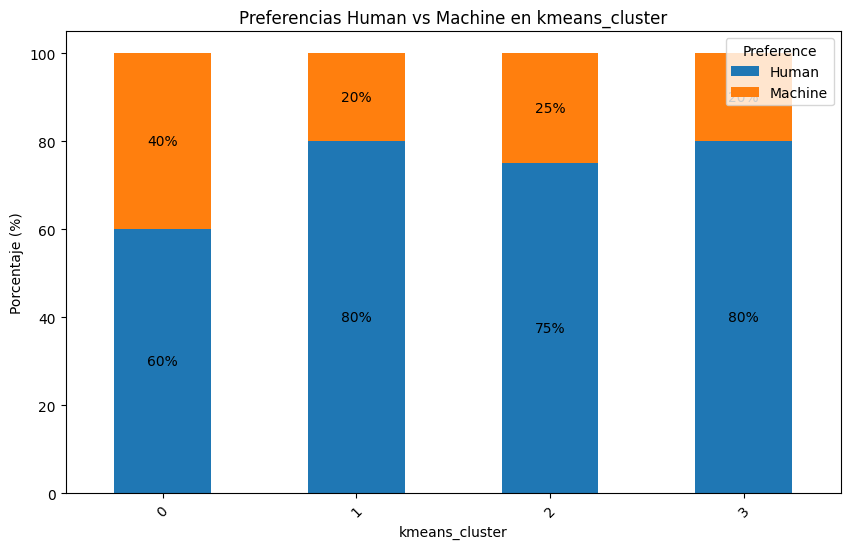

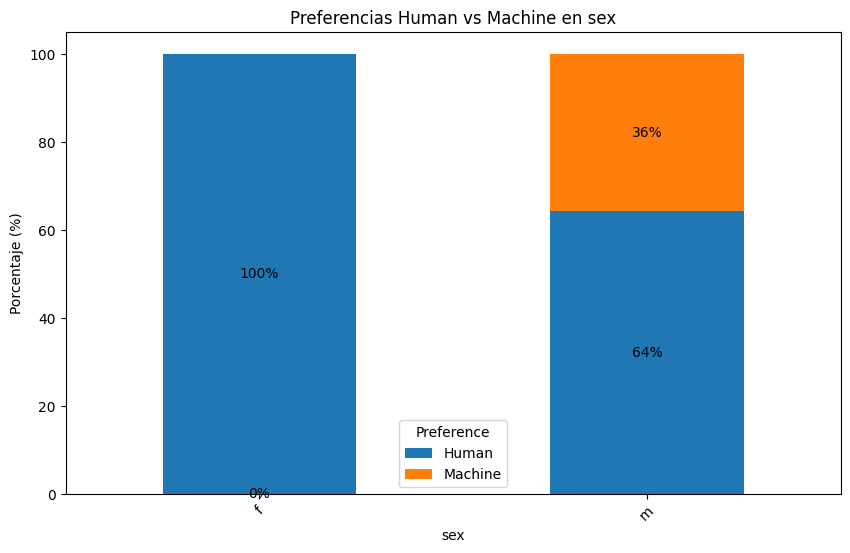

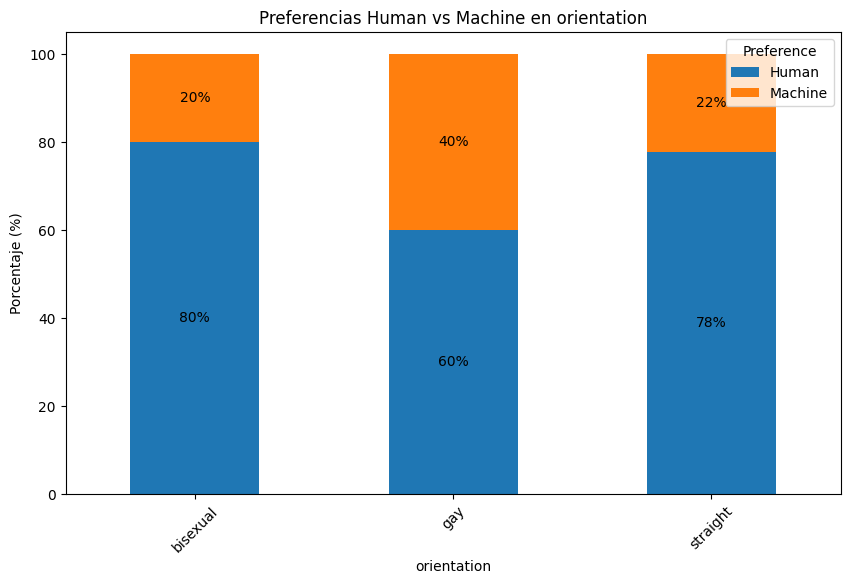

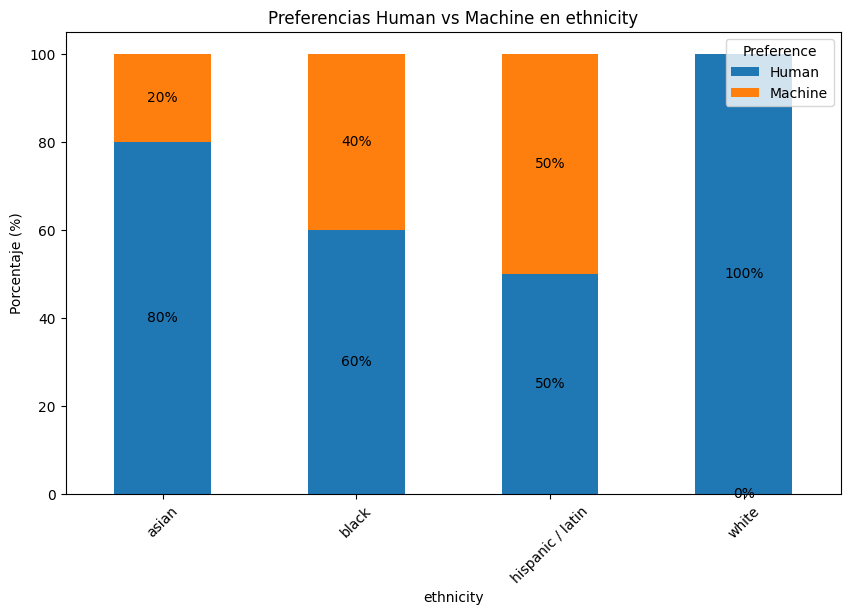

In [27]:
# Se crean gráficos para las columnas 'kmeans_cluster', 'sex', 'orientation', y 'ethnicity'

def plot_preference_percentage(data, column):
    """
    Función para crear un gráfico de barras que muestra el porcentaje de preferencias (Human vs Machine)
    para una columna específica.
    """
    # Se agrupan por la columna indicada y se extraen las preferencias
    grouped = sampled_users_df.groupby(column)['Preference'].apply(lambda x: x.str.extract(r'\((.*?)\)')[0].value_counts(normalize=True) * 100)
    grouped = grouped.unstack().fillna(0)

    # Se crea el gráfico
    ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Preferencias Human vs Machine en {column}')
    plt.ylabel('Porcentaje (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45)

    # Se añaden los porcentajes
    for bar in ax.containers:
        ax.bar_label(bar, fmt='%.0f%%', label_type='center')

    plt.legend(title='Preference')
    plt.show()

# Se crean los gráficos para las columnas especificadas
plot_preference_percentage(sampled_users_df, 'kmeans_cluster')
plot_preference_percentage(sampled_users_df, 'sex')
plot_preference_percentage(sampled_users_df, 'orientation')
plot_preference_percentage(sampled_users_df, 'ethnicity')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


WordCloud for Human Preference:


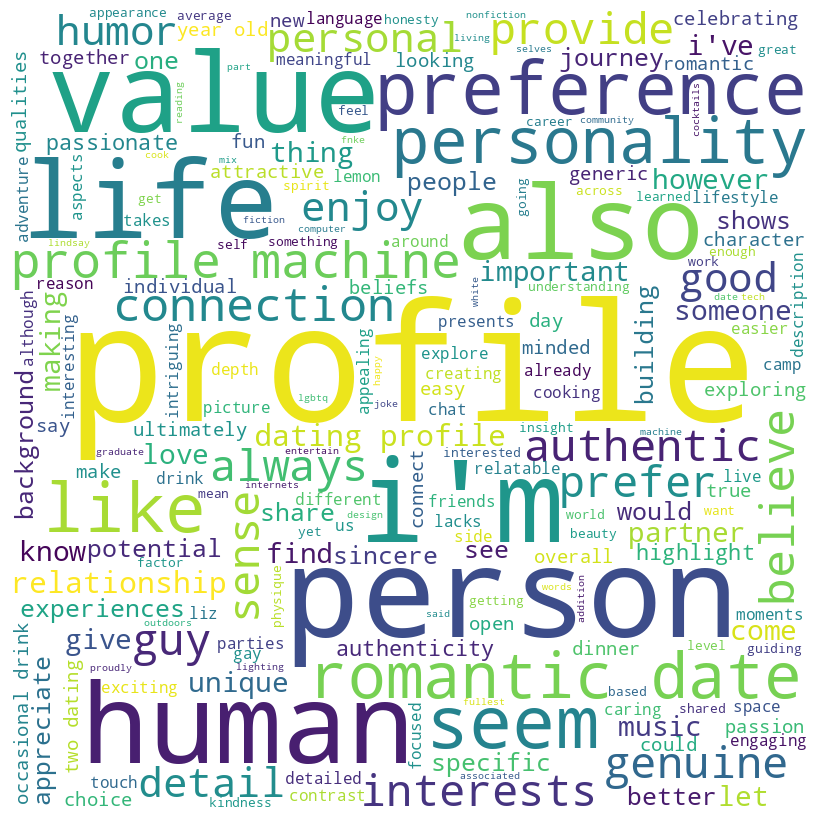

WordCloud for Machine Preference:


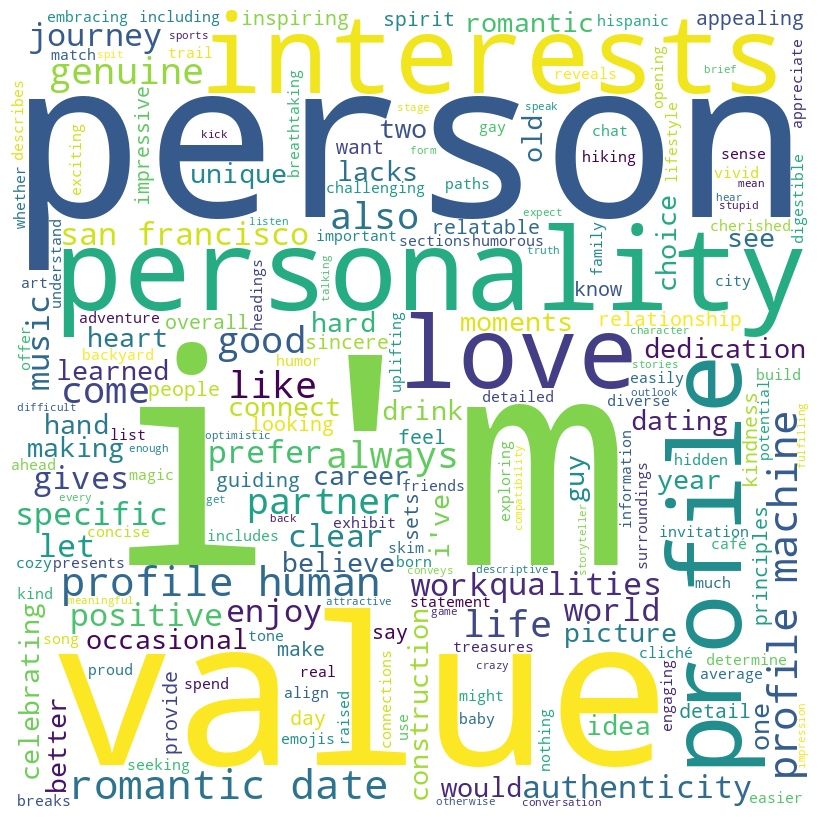

In [32]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt  # Asegúrate de importar pyplot

# Se definen los stopwords
stop_words = set(stopwords.words('english'))

# Función para crear un WordCloud
def create_wordcloud(text):
    '''
    Genera y muestra una nube de palabras a partir de un texto dado.

    Parámetros:
        text (str): El texto del cual se generarán las palabras para la nube.

    No devuelve ningún valor, pero muestra la nube de palabras generada.
    '''
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Se separan los datos según la preferencia
human_text = ' '.join(sampled_users_df[sampled_users_df['Preference'].str.contains("Human", na=False)]['Why'].dropna().str.lower())
machine_text = ' '.join(sampled_users_df[sampled_users_df['Preference'].str.contains("Machine", na=False)]['Why'].dropna().str.lower())

# Se muestran los wordclouds
print("WordCloud for Human Preference:")
create_wordcloud(human_text)

print("WordCloud for Machine Preference:")
create_wordcloud(machine_text)



In [38]:
import re
from collections import Counter

# Asegúrate de haber definido 'stop_words' en alguna parte de tu código

# Función para limpiar y contar palabras
def count_words(text):
    '''
    Cuenta la frecuencia de cada palabra en un texto, excluyendo stopwords.

    Esta función utiliza expresiones regulares para encontrar todas las palabras en el texto,
    convierte el texto a minúsculas para garantizar la consistencia, y luego cuenta la
    frecuencia de cada palabra, excluyendo stopwords.

    Parámetros:
        text (str): El texto que se va a procesar y del cual se contarán las palabras.

    Devuelve:
        collections.Counter: Un objeto Counter que contiene la frecuencia de cada palabra
        en el texto, excluyendo stopwords.
    '''
    words = re.findall(r'\w+', text.lower())
    return Counter(word for word in words if word not in stop_words)

# Se cuentan las palabras para humanos y máquinas
human_word_count = count_words(human_text)
machine_word_count = count_words(machine_text)

# Se obtienen las 10 palabras más frecuentes
top_10_human = human_word_count.most_common(10)
top_10_machine = machine_word_count.most_common(10)

# Se extraen las palabras exclusivas en cada grupo
exclusive_human = [word for word in human_word_count if word not in machine_word_count]
exclusive_machine = [word for word in machine_word_count if word not in human_word_count]

# Se extrae el Top 10 de las palabras exclusivas en cada grupo
top_10_exclusive_human = Counter({word: human_word_count[word] for word in exclusive_human}).most_common(10)
top_10_exclusive_machine = Counter({word: machine_word_count[word] for word in exclusive_machine}).most_common(10)

# Se crea un dataFrame para presentar los resultados
df = []
for i in range(10):
    df.append([
        i + 1,
        f"{top_10_human[i][0]} (Human: {top_10_human[i][1]}, Machine: {top_10_machine[i][1]})",
        f"{top_10_exclusive_human[i][0]} ({top_10_exclusive_human[i][1]})",
        f"{top_10_exclusive_machine[i][0]} ({top_10_exclusive_machine[i][1]})"
    ])

df = pd.DataFrame(df, columns=["Rank", "Most Frequent at Both", "Exclusive Human", "Exclusive Machine"])
df

,Rank,Most Frequent at Both,Exclusive Human,Exclusive Machine
0,1,"profile (Human: 39, Machine: 13)",preference (6),san (3)
1,2,"person (Human: 17, Machine: 8)",someone (5),francisco (3)
2,3,"1 (Human: 14, Machine: 7)",however (5),idea (2)
3,4,"human (Human: 13, Machine: 6)",shows (4),sets (2)
4,5,"romantic (Human: 12, Machine: 6)",experiences (4),vivid (1)
5,6,"life (Human: 12, Machine: 6)",preferences (4),including (1)
6,7,"also (Human: 11, Machine: 5)",background (4),includes (1)
7,8,"date (Human: 10, Machine: 5)",connection (4),invitation (1)
8,9,"2 (Human: 10, Machine: 5)",passionate (4),hand (1)
9,10,"machine (Human: 10, Machine: 5)",fun (3),humorous (1)
